# Prostate Cancer 🎗 detection using Adaboost from Scratch

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# Prepare Data

In [ ]:
df = pd.read_csv('../input/prostate-cancer/Prostate_Cancer.csv')
df.head()

In [ ]:
labels = df['diagnosis_result']
features = df.drop(columns=['id','diagnosis_result'])

In [ ]:
# normalize
features = (features - features.mean())/features.std()
features.head()

# replace label malignant and benignant with 0 and 1
# malignant - cancer - 1
# benignant - non-cancerous - 0
categories_to_idx = {'M' : 1, 'B' : -1}
idx_to_categories = { 1 : 'Malignant', -1 : 'Benignant'}

labels = pd.DataFrame(labels.replace(categories_to_idx))

In [ ]:
sns.pairplot(pd.concat([pd.DataFrame(labels.replace(idx_to_categories)), features], axis=1), hue="diagnosis_result")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values.reshape(-1), test_size=0.33, random_state=42)

# Adaboost definition

AdaBoost, short for Adaptive Boosting, is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire, who won the 2003 Gödel Prize for their work. It can be used in conjunction with many other types of learning algorithms to improve performance. The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. AdaBoost is sensitive to noisy data and outliers. In some problems it can be less susceptible to the overfitting problem than other learning algorithms. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner. 

Ref. [Wikipedia](https://en.wikipedia.org/wiki/AdaBoost)

# Adaboost Algorithm

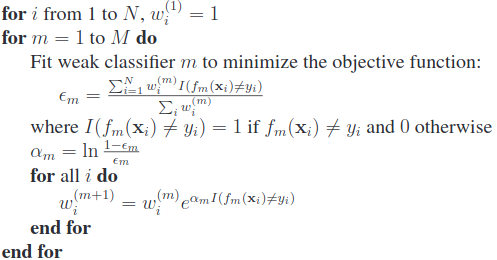

# Adaboost implementation

In [ ]:
class Adaboost():
    '''
        AdaBoost Implementation
    '''
    
    class Decision():
        def __init__(self):
            self.polarity = 1
            self.feature_idx = None
            self.threshold = None
            self.alpha = None

        def predict(self, X):
            n_samples = X.shape[0]
            X_column = X[:, self.feature_idx]
            predictions = np.ones(n_samples)
            if self.polarity == 1:
                predictions[X_column < self.threshold] = -1
            else:
                predictions[X_column > self.threshold] = -1

            return predictions

    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        
    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = self.Decision()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

In [ ]:
adaboost = Adaboost()
adaboost.fit(X_train, y_train)

# Analyze Results

In [ ]:
def get_accuracy(X, y):
    predictions = adaboost.predict(X)
    accuracy = len(np.where(predictions == y)[0]) / len(y)
    return accuracy

In [ ]:
accuracy = get_accuracy(X_train, y_train)
print("Train Accuracy: {0:1.4f}".format(accuracy))

In [ ]:
accuracy = get_accuracy(X_test, y_test)
print("Test Accuracy: {0:1.4f}".format(accuracy))